In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
# for name in dir():
#     if not name.startswith('_'):
#         del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
#from custom_classes_defs.Unet_like import * 
from custom_classes_defs.unet import *   
# from custom_classes_defs.fnet import * 
# from custom_classes_defs.fnet1 import *
# from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247
BATCH_SIZE = 512
# around 351 iterations

keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

NEW_SESSION = False

# import keras_tuner as kt
# -------------------------------------------------------

2024-05-06 20:18:42.942566: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 20:18:42.943252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 20:18:43.072705: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-06 20:18:43.335641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Verify tensorflow/keras versions
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")

# Verify CPU/GPU availability
print(tf.config.list_physical_devices())
NUM_GPU = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs assigned for computation: {NUM_GPU}")

#if NUM_GPU:
#    # print GPU info
#    !nvidia-smi

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Number of GPUs assigned for computation: 1


In [6]:
# Input data path
seis_path = './data_thebe/seis/'
label_path = './data_thebe/fault/'


In [7]:
time_start= time.time()
thebe_data = Thebe(seis_path,label_path, batch_size=BATCH_SIZE)

train_dataset = thebe_data.data_generator(sub_group='train',cache=True)
val_dataset = thebe_data.data_generator(sub_group='val',cache= True)
test_dataset = thebe_data.data_generator(sub_group='test',cache= True)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

./data_thebe/seis/train/seis_train.npy
./data_thebe/fault/train/fault_train.npy


2024-05-06 20:21:26.950441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38379 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Loading time used 3.402134895324707 mins


In [8]:
print(f"training data (size = {(train_dataset.cardinality().numpy())*BATCH_SIZE})")
print(f"validation data (size = {(val_dataset.cardinality().numpy())*BATCH_SIZE})")
print(f"test data (size = {(test_dataset.cardinality().numpy())*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])

training data (size = 181248)
validation data (size = 64512)
test data (size = 66560)
Data images tensor: TensorSpec(shape=(None, 96, 96), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 96, 96), dtype=tf.float32, name=None)


In [9]:


# Model configurations
conf = model_config(
    epochs=100,
    batch_size=BATCH_SIZE,
    verbose=0,
    scaling=1,
    save_path='./output/unet',
    img_shape= (96,96),
    target_size= (96,96),
    channels_dim=(1,1),
    pos_label= thebe_data.pos_label,
    new_training_session=True,
    mixed_precision = False,
    multiple_gpu_device=None
)


callbacks=conf.callbacks(chkpt_monitor='val_loss', lr_patience= 5)
conf.set( validation_data=val_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.Adam(1e-4), 
    metrics= ['accuracy']
)

# conf.double_check(INTERACTIVE_SESSION)
conf.info()

        compile_args:
                     optimizer: <class 'keras.src.optimizers.adam.Adam'>
                          loss: binary_crossentropy
                       metrics: accuracy
       training_args:
                        epochs: 100
                    batch_size: 512
                       shuffle: False
                       verbose: 0
               validation_data: <class 'tensorflow.python.data.ops.cache_op.CacheDataset'>
                     callbacks: <keras.src.callbacks.ReduceLROnPlateau object at 0x7f958ca4aa10>
                              : <keras.src.callbacks.ModelCheckpoint object at 0x7f958f31fcd0>
                              : <keras.src.callbacks.EarlyStopping object at 0x7f958ca4b250>
          model_arch:
                     img_shape: (96, 96)
                   target_size: (96, 96)
                  channels_dim: (1, 1)
                       scaling: 1
                  augmentation: False
new_training_session: True
           save_path: ./outp

### Build model

In [10]:
### SINGLE-HOST, MULTI-DEVICE SYNCHRONOUS TRAINING
## François Chollet. Deep Learning with Python, Second Edition (Kindle Location 12675). Manning Publications Co.. 
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))

if conf.multiple_gpu_device:

    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of devices: {strategy.num_replicas_in_sync}")
    with strategy.scope():
        m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
        model = m_obj.build_model()
        model.compile(**conf.compile_args)

else:

    m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
    # m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
    model = m_obj.build_model()
    model.compile(**conf.compile_args)

#model.summary()
#plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 3,083,969
Total trainable wieghts: 3,080,193
Total non-trainable wieghts: 3,776


### Train the model



	Train unet model
-------------------------------------------------------
Model training...


2024-05-06 20:23:39.686012: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inU-NET/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2024-05-06 20:23:41.416127: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


2024-05-06 20:24:06.050134: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8ff87d5400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-06 20:24:06.050326: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-05-06 20:24:06.189612: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


I0000 00:00:1715019847.332076 2113368 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.



Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.



Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.



Epoch 21: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.



Epoch 26: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.



Epoch 31: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.


training elapsed time: ___35.53___ minutes
...training completed!


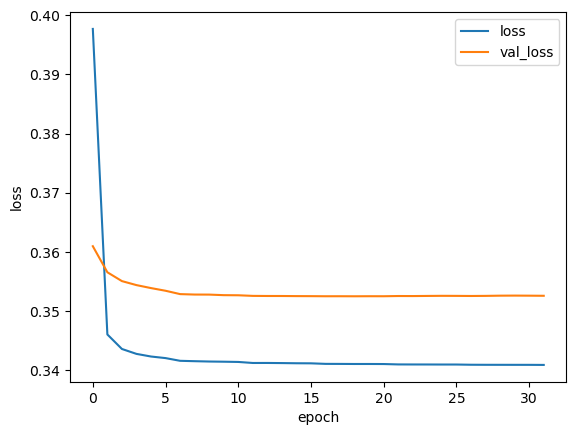

Loading time used 35.59012717008591 mins


In [11]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

model, train_history = \
    conf.execute_training(
        model, 
        data=train_dataset, 
        plot_history=INTERACTIVE_SESSION
)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

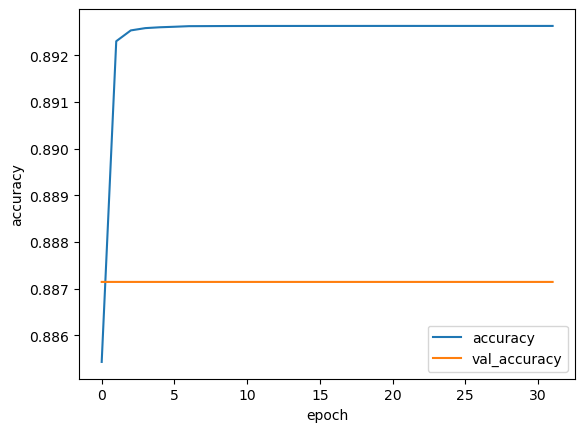

In [12]:
show_convergence(train_history.history, ['accuracy','val_accuracy'])

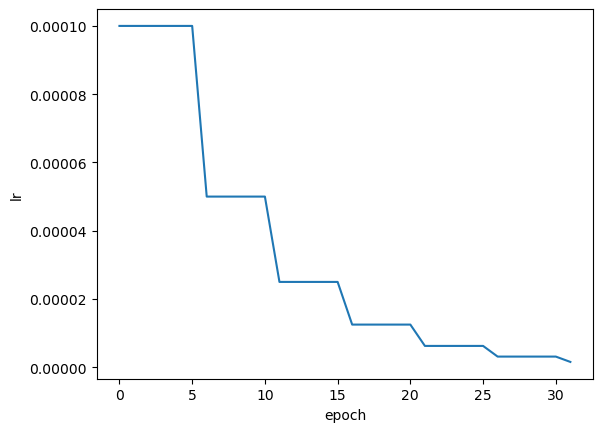

In [13]:
show_convergence(train_history.history, 'lr')

### Visualize predictions

In [14]:
time_start= time.time()
y_preds = model.predict(test_dataset)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')


  1/130 [..............................] - ETA: 6:02


  2/130 [..............................] - ETA: 6s  


  3/130 [..............................] - ETA: 6s


  5/130 [>.............................] - ETA: 6s


  7/130 [>.............................] - ETA: 6s


  9/130 [=>............................] - ETA: 5s


 11/130 [=>............................] - ETA: 5s


 13/130 [==>...........................] - ETA: 5s


 15/130 [==>...........................] - ETA: 5s


 17/130 [==>...........................] - ETA: 5s


 19/130 [===>..........................] - ETA: 5s


 21/130 [===>..........................] - ETA: 5s


 23/130 [====>.........................] - ETA: 5s


 25/130 [====>.........................] - ETA: 5s


 26/130 [=====>........................] - ETA: 4s


 28/130 [=====>........................] - ETA: 4s


 30/130 [=====>........................] - ETA: 4s


 32/130 [======>.......................] - ETA: 4s


 34/130 [======>.......................] - ETA: 4s


 36/130 [=======>......................] - ETA: 4s


 38/130 [=======>......................] - ETA: 4s


 40/130 [========>.....................] - ETA: 4s


 42/130 [========>.....................] - ETA: 4s


 44/130 [=========>....................] - ETA: 4s


 46/130 [=========>....................] - ETA: 3s


 48/130 [==========>...................] - ETA: 3s


 50/130 [==========>...................] - ETA: 3s


 52/130 [===========>..................] - ETA: 3s


 54/130 [===========>..................] - ETA: 3s


 56/130 [===========>..................] - ETA: 3s


 58/130 [============>.................] - ETA: 3s


 59/130 [============>.................] - ETA: 3s


 61/130 [=============>................] - ETA: 3s


 63/130 [=============>................] - ETA: 3s


 64/130 [=============>................] - ETA: 3s


 66/130 [==============>...............] - ETA: 3s


 68/130 [==============>...............] - ETA: 2s


 70/130 [===============>..............] - ETA: 2s


 72/130 [===============>..............] - ETA: 2s


 74/130 [================>.............] - ETA: 2s


 75/130 [================>.............] - ETA: 2s


 77/130 [================>.............] - ETA: 2s


 79/130 [=================>............] - ETA: 2s


 81/130 [=================>............] - ETA: 2s


 83/130 [==================>...........] - ETA: 2s


 85/130 [==================>...........] - ETA: 2s


 87/130 [===================>..........] - ETA: 2s


 88/130 [===================>..........] - ETA: 1s


 90/130 [===================>..........] - ETA: 1s


 92/130 [====================>.........] - ETA: 1s


 94/130 [====================>.........] - ETA: 1s


 96/130 [=====================>........] - ETA: 1s


 98/130 [=====================>........] - ETA: 1s


100/130 [======================>.......] - ETA: 1s


102/130 [======================>.......] - ETA: 1s


104/130 [=======================>......] - ETA: 1s


106/130 [=======================>......] - ETA: 1s


108/130 [=======================>......] - ETA: 1s


110/130 [========================>.....] - ETA: 0s


112/130 [========================>.....] - ETA: 0s


114/130 [=========================>....] - ETA: 0s


116/130 [=========================>....] - ETA: 0s


118/130 [==========================>...] - ETA: 0s


120/130 [==========================>...] - ETA: 0s


122/130 [===========================>..] - ETA: 0s


124/130 [===========================>..] - ETA: 0s


126/130 [============================>.] - ETA: 0s


128/130 [============================>.] - ETA: 0s


130/130 [==============================] - ETA: 0s


130/130 [==============================] - 10s 53ms/step


Loading time used 0.21800732215245563 mins


In [15]:
time_start= time.time()

print("\n\n{}\n\t{}\n{}".format('='*55,f'Evaluate {m_obj.Name} model', '-'*55))

model.evaluate(x=test_dataset)
time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')



	Evaluate unet model
-------------------------------------------------------

  1/130 [..............................] - ETA: 7s - loss: 0.3397 - accuracy: 0.8934


  2/130 [..............................] - ETA: 7s - loss: 0.3387 - accuracy: 0.8939


  3/130 [..............................] - ETA: 7s - loss: 0.3407 - accuracy: 0.8929


  4/130 [..............................] - ETA: 7s - loss: 0.3420 - accuracy: 0.8923


  5/130 [>.............................] - ETA: 6s - loss: 0.3417 - accuracy: 0.8925


  6/130 [>.............................] - ETA: 6s - loss: 0.3405 - accuracy: 0.8930


  7/130 [>.............................] - ETA: 6s - loss: 0.3395 - accuracy: 0.8935


  8/130 [>.............................] - ETA: 6s - loss: 0.3397 - accuracy: 0.8934


  9/130 [=>............................] - ETA: 6s - loss: 0.3390 - accuracy: 0.8938


 10/130 [=>............................] - ETA: 6s - loss: 0.3391 - accuracy: 0.8937


 11/130 [=>............................] - ETA: 6s - loss: 0.3392 - accuracy: 0.8937


 12/130 [=>............................] - ETA: 6s - loss: 0.3388 - accuracy: 0.8939


 13/130 [==>...........................] - ETA: 6s - loss: 0.3381 - accuracy: 0.8942


 14/130 [==>...........................] - ETA: 6s - loss: 0.3380 - accuracy: 0.8943


 15/130 [==>...........................] - ETA: 6s - loss: 0.3386 - accuracy: 0.8940


 16/130 [==>...........................] - ETA: 5s - loss: 0.3384 - accuracy: 0.8941


 17/130 [==>...........................] - ETA: 5s - loss: 0.3386 - accuracy: 0.8940


 18/130 [===>..........................] - ETA: 5s - loss: 0.3386 - accuracy: 0.8940


 19/130 [===>..........................] - ETA: 5s - loss: 0.3385 - accuracy: 0.8940


 20/130 [===>..........................] - ETA: 5s - loss: 0.3385 - accuracy: 0.8940


 21/130 [===>..........................] - ETA: 5s - loss: 0.3382 - accuracy: 0.8942


 22/130 [====>.........................] - ETA: 5s - loss: 0.3383 - accuracy: 0.8941


 24/130 [====>.........................] - ETA: 5s - loss: 0.3380 - accuracy: 0.8942


 25/130 [====>.........................] - ETA: 5s - loss: 0.3381 - accuracy: 0.8942


 26/130 [=====>........................] - ETA: 5s - loss: 0.3384 - accuracy: 0.8941


 27/130 [=====>........................] - ETA: 5s - loss: 0.3384 - accuracy: 0.8941


 28/130 [=====>........................] - ETA: 5s - loss: 0.3382 - accuracy: 0.8941


 29/130 [=====>........................] - ETA: 5s - loss: 0.3385 - accuracy: 0.8940


 30/130 [=====>........................] - ETA: 5s - loss: 0.3383 - accuracy: 0.8941


 31/130 [======>.......................] - ETA: 5s - loss: 0.3383 - accuracy: 0.8941


 32/130 [======>.......................] - ETA: 5s - loss: 0.3384 - accuracy: 0.8941


 33/130 [======>.......................] - ETA: 5s - loss: 0.3384 - accuracy: 0.8941


 34/130 [======>.......................] - ETA: 4s - loss: 0.3383 - accuracy: 0.8941


 35/130 [=======>......................] - ETA: 4s - loss: 0.3382 - accuracy: 0.8941


 36/130 [=======>......................] - ETA: 4s - loss: 0.3382 - accuracy: 0.8942


 37/130 [=======>......................] - ETA: 4s - loss: 0.3383 - accuracy: 0.8941


 38/130 [=======>......................] - ETA: 4s - loss: 0.3383 - accuracy: 0.8941


 39/130 [========>.....................] - ETA: 4s - loss: 0.3382 - accuracy: 0.8941


 40/130 [========>.....................] - ETA: 4s - loss: 0.3383 - accuracy: 0.8941


 41/130 [========>.....................] - ETA: 4s - loss: 0.3383 - accuracy: 0.8941


 43/130 [========>.....................] - ETA: 4s - loss: 0.3385 - accuracy: 0.8940


 44/130 [=========>....................] - ETA: 4s - loss: 0.3384 - accuracy: 0.8940


 45/130 [=========>....................] - ETA: 4s - loss: 0.3385 - accuracy: 0.8940


 46/130 [=========>....................] - ETA: 4s - loss: 0.3387 - accuracy: 0.8939


 47/130 [=========>....................] - ETA: 4s - loss: 0.3386 - accuracy: 0.8940


 48/130 [==========>...................] - ETA: 4s - loss: 0.3388 - accuracy: 0.8939


 49/130 [==========>...................] - ETA: 4s - loss: 0.3389 - accuracy: 0.8938


 51/130 [==========>...................] - ETA: 4s - loss: 0.3389 - accuracy: 0.8938


 52/130 [===========>..................] - ETA: 4s - loss: 0.3388 - accuracy: 0.8939


 53/130 [===========>..................] - ETA: 3s - loss: 0.3389 - accuracy: 0.8938


 54/130 [===========>..................] - ETA: 3s - loss: 0.3389 - accuracy: 0.8938


 55/130 [===========>..................] - ETA: 3s - loss: 0.3388 - accuracy: 0.8939


 56/130 [===========>..................] - ETA: 3s - loss: 0.3390 - accuracy: 0.8938


 57/130 [============>.................] - ETA: 3s - loss: 0.3389 - accuracy: 0.8938


 58/130 [============>.................] - ETA: 3s - loss: 0.3389 - accuracy: 0.8938


 59/130 [============>.................] - ETA: 3s - loss: 0.3388 - accuracy: 0.8939


 60/130 [============>.................] - ETA: 3s - loss: 0.3388 - accuracy: 0.8939


 61/130 [=============>................] - ETA: 3s - loss: 0.3388 - accuracy: 0.8939


 62/130 [=============>................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8939


 63/130 [=============>................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8939


 64/130 [=============>................] - ETA: 3s - loss: 0.3387 - accuracy: 0.8939


 65/130 [==============>...............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8940


 66/130 [==============>...............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8940


 67/130 [==============>...............] - ETA: 3s - loss: 0.3387 - accuracy: 0.8939


 68/130 [==============>...............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8940


 69/130 [==============>...............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8939


 70/130 [===============>..............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8940


 71/130 [===============>..............] - ETA: 3s - loss: 0.3386 - accuracy: 0.8939


 72/130 [===============>..............] - ETA: 2s - loss: 0.3387 - accuracy: 0.8939


 73/130 [===============>..............] - ETA: 2s - loss: 0.3387 - accuracy: 0.8939


 74/130 [================>.............] - ETA: 2s - loss: 0.3388 - accuracy: 0.8939


 75/130 [================>.............] - ETA: 2s - loss: 0.3388 - accuracy: 0.8939


 76/130 [================>.............] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938


 77/130 [================>.............] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938


 78/130 [=================>............] - ETA: 2s - loss: 0.3390 - accuracy: 0.8938


 79/130 [=================>............] - ETA: 2s - loss: 0.3391 - accuracy: 0.8937


 80/130 [=================>............] - ETA: 2s - loss: 0.3391 - accuracy: 0.8937


 81/130 [=================>............] - ETA: 2s - loss: 0.3390 - accuracy: 0.8938


 82/130 [=================>............] - ETA: 2s - loss: 0.3390 - accuracy: 0.8938


 83/130 [==================>...........] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938


 84/130 [==================>...........] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938


 85/130 [==================>...........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8939


 86/130 [==================>...........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8939


 87/130 [===================>..........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8939


 88/130 [===================>..........] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938


 89/130 [===================>..........] - ETA: 2s - loss: 0.3389 - accuracy: 0.8938


 91/130 [====================>.........] - ETA: 2s - loss: 0.3388 - accuracy: 0.8939


 92/130 [====================>.........] - ETA: 1s - loss: 0.3388 - accuracy: 0.8938


 93/130 [====================>.........] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


 94/130 [====================>.........] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


 96/130 [=====================>........] - ETA: 1s - loss: 0.3390 - accuracy: 0.8938


 97/130 [=====================>........] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


 98/130 [=====================>........] - ETA: 1s - loss: 0.3388 - accuracy: 0.8939


 99/130 [=====================>........] - ETA: 1s - loss: 0.3388 - accuracy: 0.8939


100/130 [======================>.......] - ETA: 1s - loss: 0.3388 - accuracy: 0.8939


101/130 [======================>.......] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


102/130 [======================>.......] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


103/130 [======================>.......] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


104/130 [=======================>......] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


105/130 [=======================>......] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


106/130 [=======================>......] - ETA: 1s - loss: 0.3389 - accuracy: 0.8938


107/130 [=======================>......] - ETA: 1s - loss: 0.3390 - accuracy: 0.8938


108/130 [=======================>......] - ETA: 1s - loss: 0.3390 - accuracy: 0.8938


109/130 [========================>.....] - ETA: 1s - loss: 0.3390 - accuracy: 0.8938


110/130 [========================>.....] - ETA: 1s - loss: 0.3390 - accuracy: 0.8938


111/130 [========================>.....] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


112/130 [========================>.....] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


113/130 [=========================>....] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


114/130 [=========================>....] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


115/130 [=========================>....] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


116/130 [=========================>....] - ETA: 0s - loss: 0.3389 - accuracy: 0.8938


117/130 [==========================>...] - ETA: 0s - loss: 0.3389 - accuracy: 0.8938


118/130 [==========================>...] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


119/130 [==========================>...] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


120/130 [==========================>...] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


121/130 [==========================>...] - ETA: 0s - loss: 0.3389 - accuracy: 0.8938


122/130 [===========================>..] - ETA: 0s - loss: 0.3390 - accuracy: 0.8938


123/130 [===========================>..] - ETA: 0s - loss: 0.3389 - accuracy: 0.8938


124/130 [===========================>..] - ETA: 0s - loss: 0.3389 - accuracy: 0.8938


125/130 [===========================>..] - ETA: 0s - loss: 0.3388 - accuracy: 0.8939


126/130 [============================>.] - ETA: 0s - loss: 0.3388 - accuracy: 0.8939


127/130 [============================>.] - ETA: 0s - loss: 0.3388 - accuracy: 0.8939


128/130 [============================>.] - ETA: 0s - loss: 0.3388 - accuracy: 0.8939


129/130 [============================>.] - ETA: 0s - loss: 0.3388 - accuracy: 0.8939


130/130 [==============================] - 7s 51ms/step - loss: 0.3388 - accuracy: 0.8939


Loading time used 0.11095335483551025 mins


In [16]:
time_start= time.time()

# Using scikit-learn
scores = m_obj.evaluate_sklearn(test_dataset, y_preds,report=True)
print(scores)

time_end = (time.time()-time_start)/60
print(f'Loading time used {time_end} mins')

evaluation elapsed time:___31.51___minutes
                      0            1  accuracy     macro avg  weighted avg
precision  9.000000e-01         0.11       0.5  5.000000e-01  8.100000e-01
recall     5.000000e-01         0.51       0.5  5.000000e-01  5.000000e-01
f1-score   6.400000e-01         0.18       0.5  4.100000e-01  5.900000e-01
support    5.443481e+08  64617490.00       0.5  6.089656e+08  6.089656e+08
{'Avg-precision': 0.11, 'f1-score(ODS)': 0.18}
Loading time used 31.510384472211204 mins


In [17]:
if NEW_SESSION:
    thebe_data.display_sample_image(y_preds, 'test')